In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive',force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive"

 Archive.zip   Personal		  Salary_Prediction.zip
 flower_data   RazamSBI.txt.zip  'TA Work'


In [4]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
  
!pip install Pillow
!pip install image

In [0]:
import os

import numpy as np
import json
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torch import optim
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from torch import utils

In [6]:
#Check if GPU is available
if torch.cuda.is_available():
    print("CUDA is available")
    device = "cuda"
else:
    print("CUDA is not available, using cpu")
    device = "cpu"

CUDA is available


In [7]:
#1. Load the Data
image_dir = os.path.join("/content/drive/My Drive","flower_data")
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
image_size = (255,255)
crop_size=244
random_transforms = [
                    #transforms.ColorJitter(brightness=0.2, contrast=0.6, saturation=0.4, hue=0.5),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    transforms.RandomRotation(torch.randint(low=0,high=360,size=(1,)).item())
                        ]
train_transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(crop_size),
                                transforms.RandomApply(random_transforms, p=0.8),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485,0.456,0.406),
                                                   (0.229,0.224,0.225))
                                ])

transform = transforms.Compose([transforms.Resize(image_size),
                                #transforms.Grayscale(),
                                transforms.CenterCrop(crop_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485,0.456,0.406),
                                                   (0.229,0.224,0.225))
                                ])

# choose the training and test datasets
train_dir = os.path.join(image_dir,"train")
test_dir = os.path.join(image_dir,"valid")

train_data = datasets.ImageFolder(train_dir,transform=train_transform)
train_loader = utils.data.DataLoader(train_data,batch_size=batch_size, 
                                         shuffle = True,num_workers=num_workers)

validation_data = datasets.ImageFolder(test_dir,transform=transform)
validation_loader = utils.data.DataLoader(validation_data,batch_size=batch_size, 
                                        shuffle = True,num_workers=num_workers)

print("Total number of train Images:%d"%(len(train_loader.dataset)))
print("Total number of test Images:%d"%(len(validation_loader.dataset)))


Total number of train Images:6552
Total number of test Images:818


In [0]:
#Load the classes
with open(os.path.join(image_dir,"cat_to_name.json"),'r') as f:
    classes=json.load(f)

In [0]:
def build_model(pre_train_name=""):
    """
        Create a NN Topology using pre-trained model or new network from scratch
        parameters:
            input:
                pre_train_name : pretrained network name like VGG, RESNET,etc
    """
    pre_train_name = pre_train_name.upper()
    
    if pre_train_name == 'VGG':
        model = models.vgg19(pretrained=True)
    elif pre_train_name == 'RESNET':
        model = models.resnet50(pretrained=True)
    elif pre_train_name == 'INCEPTION':
        model = models.inception_v3(pretrained=True)
    else:
        ##TO DO
        #model = N.Network()
        pass
        
    if pre_train_name == 'VGG':
       #turn off gradients
        for param in model.parameters():
            param.requires_grad = False
    
        classifier = nn.Sequential(nn.Linear(25088,4096),
                               nn.ReLU(),
                               nn.Dropout(p=0.2),
                               nn.Linear(4096,2048),
                               nn.ReLU(),
                               nn.Dropout(p=0.2),
                               nn.Linear(2048,512),
                               nn.ReLU(),
                               nn.Dropout(p=0.2),
                               nn.Linear(512,102)
                                )
        model.classifier = classifier
    
    if (pre_train_name == 'RESNET'
    or  pre_train_name == 'INCEPTION'):
       #turn off gradients
        for param in model.parameters():
            param.requires_grad = False
    
        classifier = nn.Sequential(nn.Linear(2048,512),
                               nn.ReLU(),
                               nn.Dropout(p=0.4),
                               nn.Linear(512,102)
                                )
        model.fc = classifier 
    
    # specify loss function (categorical cross-entropy)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.classifier.parameters(),lr=0.003)
    print(model)
    
    return model, criterion, optimizer

def train(model,criterion,optimizer,train_loader):
    """
        Create a NN Topology using pre-trained model or new network from scratch
        parameters:
            input:
                model : model to train
                criterion : loss function
                optimizer : optimizer to minmize the loss
                train_loader : Train data iterator
            output:
                training loss
    """
    train_loss = 0.0
        
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if device == 'cuda':
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    return train_loss 


def validate(model,criterion,optimizer,validation_loader):
    """
        Create a NN Topology using pre-trained model or new network from scratch
        parameters:
            input:
                model : model to train
                criterion : loss function
                optimizer : optimizer to minmize the loss
                validation_loader : validation data iterator
            output:
                validation loss
    """
    valid_loss = 0
    model.eval()
    for data, target in validation_loader:
        # move tensors to GPU if CUDA is available
        if device == 'cuda':
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    return valid_loss
    
def save_model(path,model,optimizer,epoch,loss,class_index):
    """
        Save the model to specified path
        parameters:
            input:
                model

    """    
    torch.save({
            #'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            #'loss': loss,
            'class_idx':class_index
            }, path)

def load_model(path):
    """
        Load the model from given path
        parameters:
            input:
                path
                model
            output:
                model, criterion, optimizermodel, criterion, optimizer, epoch, loss, class_index
    """   
    model, criterion, optimizer = build_model('VGG')
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    epoch, loss, class_index = {},{},{}
    if 'epoch' in checkpoint:
      epoch = checkpoint['epoch']
    if 'loss' in checkpoint:
      loss = checkpoint['loss']
    if 'class_idx' in checkpoint:
      class_index = checkpoint['class_idx']
      
    return model, criterion, optimizer, epoch, loss, class_index

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    img = process_image(image_path)
    img = torch.from_numpy(img)
    #img = transform(img)
    #Display Image
    #imshow(img)
    
    #prediction
    img.unsqueeze_(0)  #Add Batch dimension
    
    if device == 'cuda':
        img, model  = img.cuda(), model.cuda()
    
    output = F.softmax(model(img))
    # convert output probabilities to predicted class
    pred_prob, pred_label = output.topk(topk)    
    
    return pred_prob, pred_label
      
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    im = Image.open(image)
    im=transform(im)
    im_np = np.asarray(im)
    return im_np
    
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    #image = image.numpy().transpose((1,2,0)) if not device == 'cuda' else image.cpu().transpose((1,2,0))
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


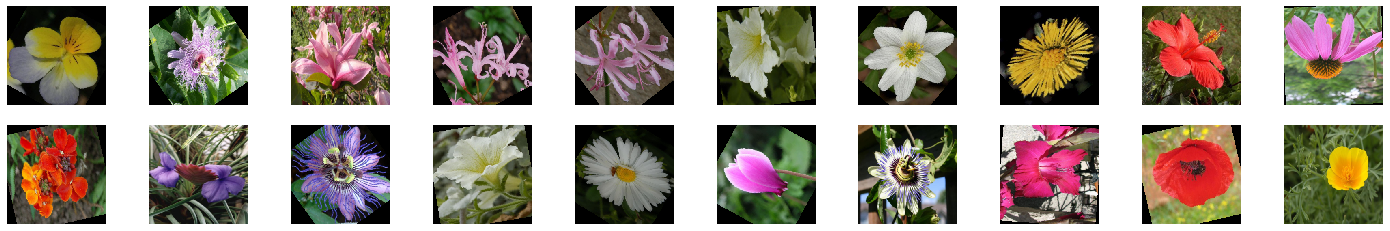

In [10]:
#Sanity check for train images
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
#images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx],ax,title=classes[str(labels[idx].numpy().item())])
    #ax.set_title(classes[str(labels[idx].numpy().item())])

In [11]:
# specify loss function (categorical cross-entropy)
save_path = os.path.join(os.getcwd(),'model_classification.pt')
model, criterion, optimizer=build_model('VGG')

model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:07<00:00, 80378950.54it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [0]:
#Train the model, validate and caluclate the losses
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = train(model,criterion,optimizer,train_loader)
    valid_loss = validate(model,criterion,optimizer,validation_loader)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(validation_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        class_index=train_loader.dataset.class_to_idx
        save_model(save_path,model,optimizer,epoch,valid_loss,class_index)
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 1.431290 	Validation Loss: 0.867247
Validation loss decreased (inf --> 0.867247).  Saving model ...
Epoch: 2 	Training Loss: 1.423215 	Validation Loss: 0.917544
Epoch: 3 	Training Loss: 1.411862 	Validation Loss: 0.974653
Epoch: 4 	Training Loss: 1.414157 	Validation Loss: 0.932828
Epoch: 5 	Training Loss: 1.427508 	Validation Loss: 0.911309
Epoch: 6 	Training Loss: 1.351363 	Validation Loss: 0.879286
Epoch: 7 	Training Loss: 1.332014 	Validation Loss: 0.867664
Epoch: 8 	Training Loss: 1.382547 	Validation Loss: 0.977657
Epoch: 9 	Training Loss: 1.351658 	Validation Loss: 0.834733
Validation loss decreased (0.867247 --> 0.834733).  Saving model ...
Epoch: 10 	Training Loss: 1.266824 	Validation Loss: 0.922367
Epoch: 11 	Training Loss: 1.366206 	Validation Loss: 0.948759
Epoch: 12 	Training Loss: 1.348378 	Validation Loss: 0.865181
Epoch: 13 	Training Loss: 1.360458 	Validation Loss: 0.898826
Epoch: 14 	Training Loss: 1.320458 	Validation Loss: 0.947306
Epoch: 1

In [0]:
model.eval()
topk=5
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
print("Checking Accuracy on Vlidation Data")
for data, target in validation_loader:
    # move tensors to GPU if CUDA is available
    if device == 'cuda':
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # convert output probabilities to predicted class
    pred_prob, pred_label = output.topk(1) 
    
    correct_tensor = pred_label.eq(target.data.view_as(pred_label))
    correct = np.squeeze(correct_tensor.numpy()) if not device == 'cuda' else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Checking Accuracy on Vlidation Data

Test Accuracy (Overall): 77% (637/818)


In [94]:
load_path = os.path.join(image_dir,'model_classification.pt')
model, criterion, optimizer, epoch, loss, class_index = load_model(load_path)
class_index_rev = {ii:label for label,ii in class_index.items()}


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

Checking Accuracy on Vlidation Data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[0.6691, 0.2454, 0.0397, 0.0120, 0.0113]], device='cuda:0')
tensor([[ 0, 87, 13, 84, 61]], device='cuda:0')
tensor([[0.4489, 0.3130, 0.0992, 0.0428, 0.0423]], device='cuda:0')
tensor([[ 0, 87, 49, 61, 84]], device='cuda:0')
tensor([[0.6408, 0.2029, 0.0405, 0.0267, 0.0184]], device='cuda:0')
tensor([[ 76,   0,  13,  87, 100]], device='cuda:0')
tensor([[0.1874, 0.0512, 0.0490, 0.0404, 0.0400]], device='cuda:0')
tensor([[ 0, 49, 99, 14, 61]], device='cuda:0')
tensor([[0.8195, 0.0482, 0.0418, 0.0187, 0.0111]], device='cuda:0')
tensor([[ 0, 66, 13, 99, 76]], device='cuda:0')
tensor([[0.2215, 0.1353, 0.1043, 0.0903, 0.0852]], device='cuda:0')
tensor([[ 0, 76, 99, 49, 84]], device='cuda:0')
tensor([[0.9892, 0.0082, 0.0006, 0.0005, 0.0003]], device='cuda:0')
tensor([[49, 28, 26,  0, 72]], device='cuda:0')
tensor([[0.4222, 0.1493, 0.0926, 0.0617, 0.0551]], device='cuda:0')
tensor([[  0,  13,  49, 100,  99]], device='cuda:0')
tensor([[0.6344, 0.2379, 0.0732, 0.0257, 0.0132]], device='cud

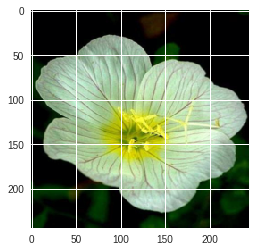

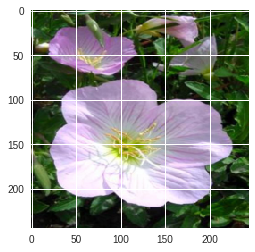

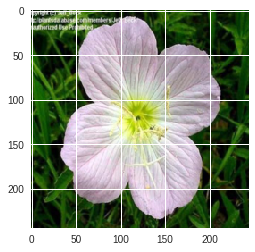

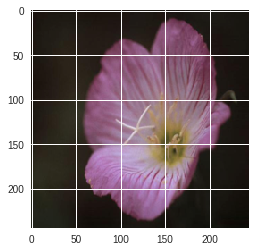

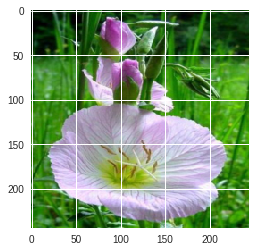

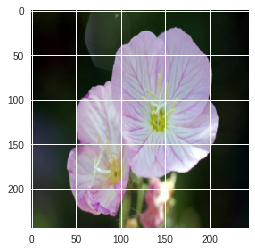

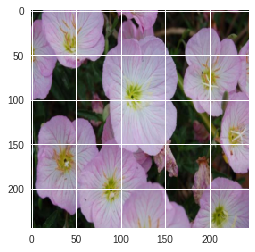

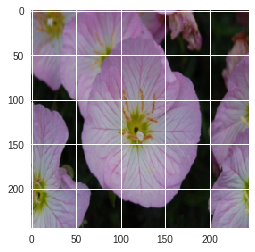

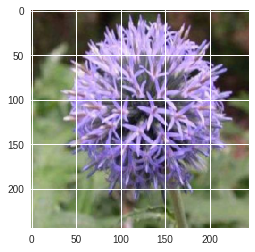

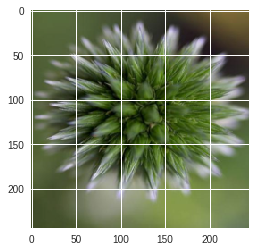

In [95]:
print("Checking Accuracy on Vlidation Data")

for item in validation_data.imgs[:10]:
    # move tensors to GPU if CUDA is available
    image_path = item[0]
    probs, pred_classes = predict(image_path, model)
    print(probs.data)
    print(pred_classes.data)

In [0]:
def view_classify(img, prob,labels):
    ''' Function for viewing an image and it's predicted classes.
    '''
    prob = np.squeeze(prob.data.numpy()) if not device == 'cuda' else np.squeeze(prob.data.cpu().numpy())
    labels = np.squeeze(labels.data.numpy()) if not device == 'cuda' else np.squeeze(labels.data.cpu().numpy())
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    imshow(img,ax1)
    ax1.axis('off')
    ax2.barh(np.arange(len(labels)), prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(labels)))
    ax2.set_yticklabels([classes[i] for i in [class_index_rev[x] for x in labels]])

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


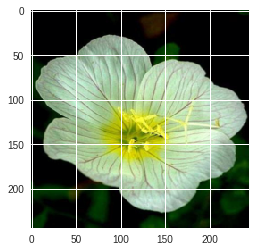

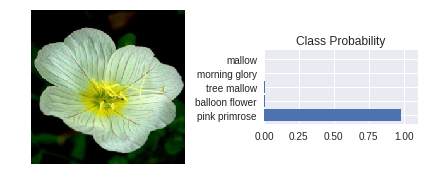

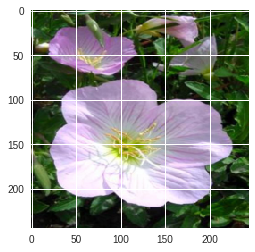

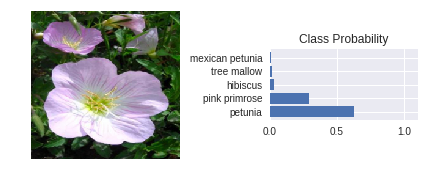

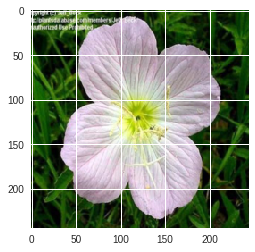

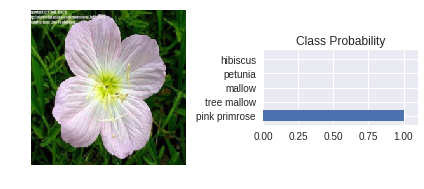

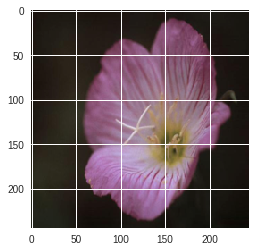

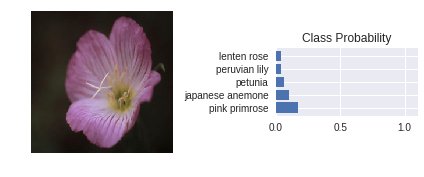

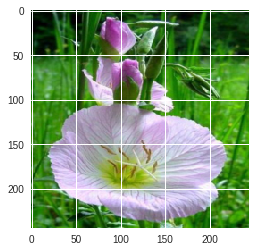

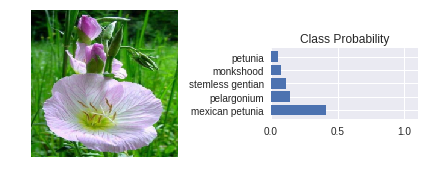

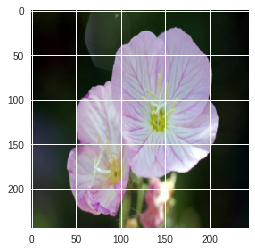

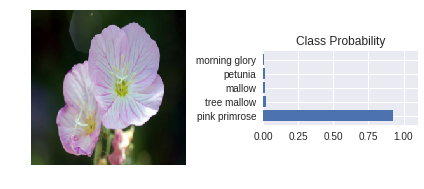

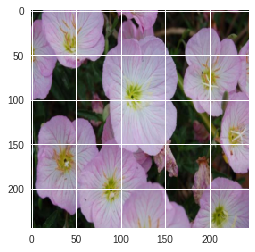

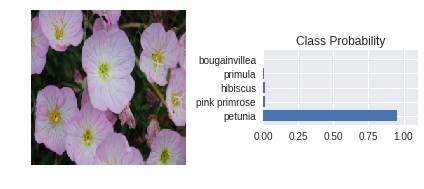

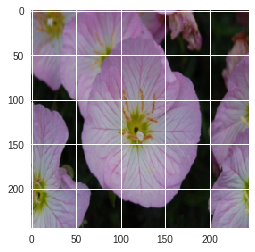

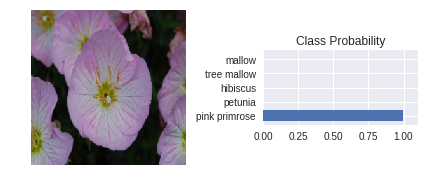

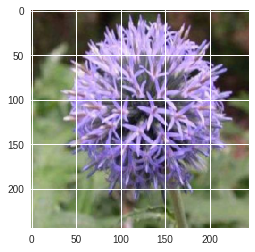

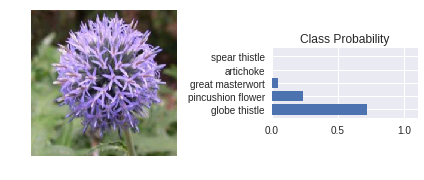

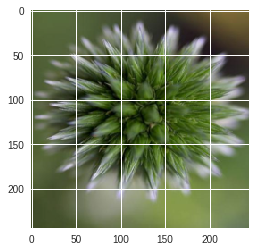

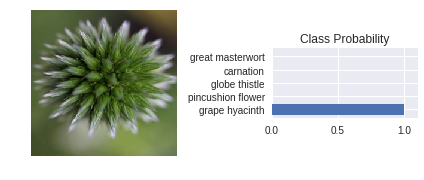

In [120]:
for item in validation_data.imgs[:10]:
    # move tensors to GPU if CUDA is available
    image_path = item[0]
    img = process_image(image_path)
    img = torch.from_numpy(img)
    probs, pred_classes = predict(image_path, model)
    view_classify(img,probs,pred_classes)

In [0]:
 y_str= [classes[i] for i in [class_index_rev[x] for x in [0,43,57,65,1]]]

In [116]:
y_str

['pink primrose',
 'wallflower',
 'orange dahlia',
 'osteospermum',
 'globe thistle']